In [98]:
@everywhere using Distributions
using PyPlot
using Interact

function plotSMC(output)
    W,X,A,ESS,M,V = output
    
    t = 1:length(A)
    
    subplot(221)
    title("dμʸ / dμ₀ (expectation estimation = $(round(vecdot(X,W)*1000)/1000))")
    PyPlot.plt[:hist](X, 40, weights=W)
    
    subplot(222)
    plot(t, M, linewidth=.5,color="black")
    fill_between(t, M-V, M+V, alpha=0.5, color="lightgrey")
    
    subplot(223)
    title("Acceptance rate (mean = $(round(mean(A) * 100)/100))")
    plot(t, A)
    plot(t, ones(A)*A[end], "r--")
    
    subplot(224)
    title("ESS (mean = $(round(mean(ESS))))")
    plot(t, ESS)
    plot(t, ones(ESS)*ESS[end], "r--");
end

@everywhere prior = Uniform(0, 5)

@everywhere p = 50
@everywhere phis = collect(linspace(0, 1, p+1))
@everywhere srand(42)
@everywhere X = rand(100) * 10
@everywhere Y = 3 * X + 0.5*randn(100)

@everywhere likelihood = (n, x) -> let
    sum((Y - x[1]*X).^2) * phis[n+1]
end


Interact.Slider{Int64}(45: "input-13" = 1 Int64 , "", 1, 1:50, "horizontal", true, "d", true)

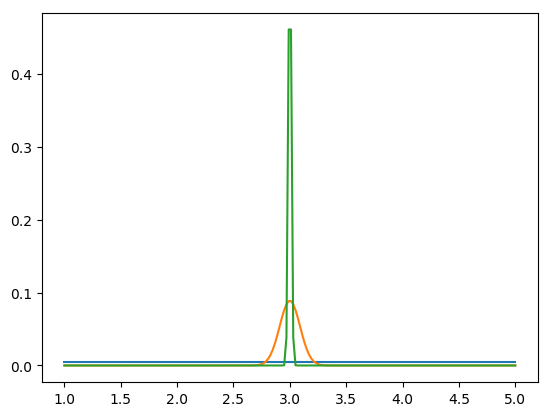

In [121]:
mesh = linspace(1, 5, 200)
fig = figure()

@manipulate for n=slider(1:p, value=1)
    l₋ = ones(mesh)
    l  = (x -> likelihood(n, x)).(mesh)
    l₊ = (x -> likelihood(n, x) / phis[n+1]).(mesh)
    
    l = exp.(-l)
    l₊ = exp.(-l₊)
    
    l₋ /= sum(l₋)
    l /= sum(l)
    l₊ /= sum(l₊)
    
    withfig(fig) do
        plot(mesh, l₋)
        plot(mesh, l)
        plot(mesh, l₊)
    end
end

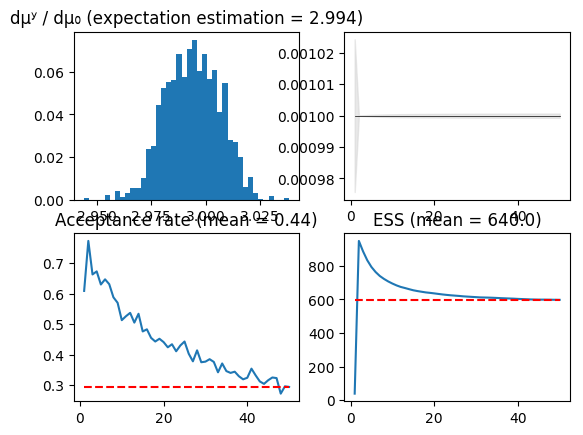

In [101]:
function noop(out) 
end

function GaussianSequentialMonteCarlo(X₀, p, prior, ll; μ=0.1,progress=noop)
    # initialization
    N,d = size(X₀)
    w = MvNormal(μ^2 * eye(d))

    X = SharedArray{Float64}(X₀)
    dX = SharedArray{Float64,2}(X₀)
    
    alphas = SharedArray{Float64}(N)
    W = SharedArray{Float64}(N)
    
    acceptance_rate = ones(p) ./ N
    ess = zeros(p)
    means = zeros(p)
    vars = zeros(p)
        
    # initialize
    s = @parallel (+) for i=1:N
        W[i] = exp(-ll(1, X[i,:]))
    end
    @sync @parallel for i=1:N
        W[i] /= s
    end
    
    for n = 1:p
        # update
        copy!(dX, rand(w, N)')
        rand!(alphas)
        
        @sync @parallel for i=1:N
            W[i] = log(W[i])
        end
        
        acceptance_rate[n] *= @parallel (+) for i=1:N
            accepted = 0
            
            xₙ₋₁ = X[i,:]
            xₙ = xₙ₋₁ + dX[i,:]

            wₙ = ll(n, xₙ)
            wₙ₋₁ = ll(n, xₙ₋₁)
            
            if alphas[i] < min(1, exp(-wₙ + wₙ₋₁))
                X[i,:] = xₙ
                accepted += 1
            end
            W[i] += ll(n-1, xₙ₋₁) - wₙ₋₁
            
            accepted
        end
        
        # normalize weights
        s = @parallel (+) for i=1:N
            W[i] = exp(W[i])
        end
        @sync @parallel for i=1:N
            W[i] /= s
        end
        
        # resample
        means[n] = mean(W)
        vars[n] = var(W)
        
        ess[n] = 1 / vecdot(W,W)
        if ess[n] < N/2            
            perm = rand(Categorical(W[:]), N)
            @sync @parallel for i=1:N
                X[i,:] = X[perm[i], :]
                W[i] = 1/N
            end 
        end
    end
    
    W,X,acceptance_rate,ess,means,vars
end

N = 1000
X₀ = reshape(rand(prior, N), N, 1)

outs = GaussianSequentialMonteCarlo(X₀, p, prior, likelihood, μ=0.05)

plotSMC(outs);

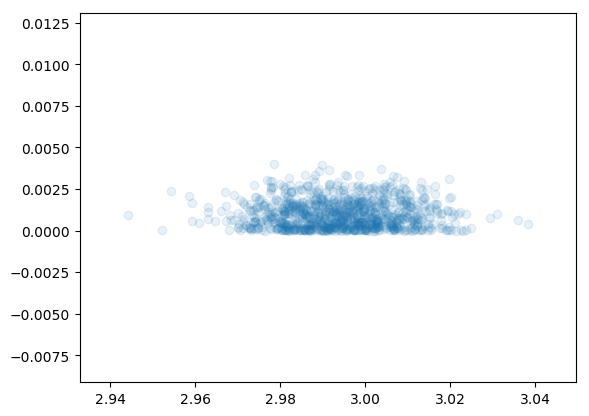

PyObject <matplotlib.collections.PathCollection object at 0x7facab1c94d0>

In [102]:
scatter(outs[2], outs[1], alpha=0.1)